<a href="https://colab.research.google.com/github/Randall19/Hello-World/blob/master/Copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.0'

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # train, validate, test ratio 8:1:1
    with_info=True,
    as_supervised=True 
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
print("Total number of samples: ", metadata.splits['train'].num_examples)

Total number of samples:  3670


In [ ]:
num_classes = metadata.features['label'].num_classes
num_train = len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

In [ ]:
print("Number of classes: ", num_classes)
print("Number of training samples: ", num_train)
print("Number fo validation samples: ", num_validation)
print("Number of test samples: ", num_test)

Number of classes:  5
Number of training samples:  2936
Number fo validation samples:  367
Number of test samples:  367


In [ ]:
print(raw_test)
print(raw_train)
print(raw_validation)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
class_names = np.array(metadata.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [ ]:
label_names = metadata.features['label'].int2str

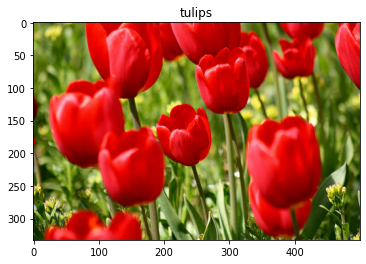

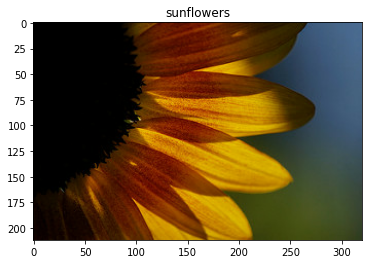

In [ ]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))


#Resize,normalize, augment shuffle and batch the data

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image =tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image/255.0
  return image, label


In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


In [ ]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image =tf.image.random_contrast(image, lower=0.0, upper = 1.0)
  image = tf.stack(image, axis=0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3 ])
  return image, label

In [ ]:
train = train.map(augment_data)

#Shuffle and batch the data set

*   List item
*   List item



In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches =test.batch(BATCH_SIZE)

In [ ]:
print(train_batches)
print(validation_batches)
print(test_batches)


<RepeatDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<RepeatDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape

TensorShape([32, 224, 224, 3])

Training, first set training parameters

In [ ]:
NUM_EPOCHES = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps =round(num_validation)//BATCH_SIZE

def display_training_curves(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epoch_range = range(NUM_EPOCHES)

  plt.plot(epoch_range, acc, label = 'Train accuracy')
  plt.plot(epoch_range, val_acc, label= 'Val accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

In [ ]:
def build_model_from_scratch():
  model = Sequential([
                      Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=IMG_SHAPE),
                      MaxPooling2D(pool_size=2),

                      Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
                      MaxPooling2D(pool_size=2),

                      Flatten(),
                      Dense(64, activation='relu'),
                      Dense(num_classes, activation='softmax')
  ])
  return model

In [ ]:
simple_cnn_model = build_model_from_scratch()

In [ ]:
simple_cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                12845120  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

Compile and Run the Code

In [ ]:
def train_model(model):
  model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy')
  
  history = model.fit(train_batches,
                      epochs=NUM_EPOCHES,
                      validation_data=validation_batches,
                      steps_per_epoch=steps_per_epoch,
                      validation_steps=validation_steps)
  return history
  

In [ ]:
%time
history = train_model(simple_cnn_model)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Epoch 1/10
91/91 [==============================] - 10s 87ms/step - loss: 0.2385 - accuracy: 0.9096 - val_loss: 4.2440 - val_accuracy: 0.6023
Epoch 2/10
91/91 [==============================] - 9s 100ms/step - loss: 0.2137 - accuracy: 0.9134 - val_loss: 4.9855 - val_accuracy: 0.5909
Epoch 3/10
91/91 [==============================] - 9s 101ms/step - loss: 0.2263 - accuracy: 0.9231 - val_loss: 5.3231 - val_accuracy: 0.5767
Epoch 4/10
91/91 [==============================] - 9s 100ms/step - loss: 0.2375 - accuracy: 0.9181 - val_loss: 4.9180 - val_accuracy: 0.5824
Epoch 5/10
91/91 [==============================] - 9s 100ms/step - loss: 0.2027 - accuracy: 0.9262 - val_loss: 4.6646 - val_accuracy: 0.6108
Epoch 6/10
91/91 [==============================] - 9s 100ms/step - loss: 0.2162 - accuracy: 0.9276 - val_loss: 5.2401 - val_accuracy: 0.6335
Epoch 7/10
91/91 [==============================] - 9s 100ms/step - loss: 0.1982 - a

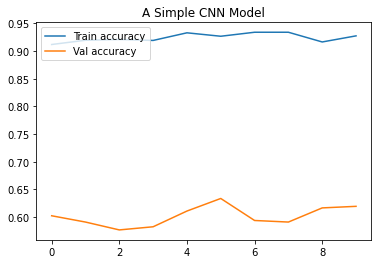

<Figure size 432x288 with 0 Axes>

In [ ]:
display_training_curves(history, "A Simple CNN Model")

Feature extraction

In [ ]:
base_model =MobileNetV2(input_shape=IMG_SHAPE,
                        weights="imagenet",
                        include_top=False)


In [ ]:
base_model.trainable =False

In [ ]:
def build_mobilenetv2_model(base_model):
  model = Sequential([
                      base_model,
                      Conv2D(32, 3, activation='relu'),
                      GlobalAveragePooling2D(),
                      Dense(num_classes, activation='softmax')]
  )
  return model
                   
                   


In [ ]:
model = build_mobilenetv2_model(base_model)


In [ ]:
model.compile(optimizer=Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'] )

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


Train the new modified model with base MobileNetV2 frozen and only trianing on a smaller set of parameters.

In [ ]:
%%time
history = model.fit(train_batches,
                      epochs=NUM_EPOCHES,
                      validation_data=validation_batches,
                      steps_per_epoch=steps_per_epoch,
                      validation_steps=validation_steps)

Epoch 1/10
91/91 [==============================] - 12s 87ms/step - loss: 1.2866 - accuracy: 0.5328 - val_loss: 0.5592 - val_accuracy: 0.7898
Epoch 2/10
91/91 [==============================] - 9s 95ms/step - loss: 0.5780 - accuracy: 0.7837 - val_loss: 0.3973 - val_accuracy: 0.8693
Epoch 3/10
91/91 [==============================] - 9s 96ms/step - loss: 0.4951 - accuracy: 0.8223 - val_loss: 0.3998 - val_accuracy: 0.8835
Epoch 4/10
91/91 [==============================] - 9s 95ms/step - loss: 0.4427 - accuracy: 0.8290 - val_loss: 0.3510 - val_accuracy: 0.8835
Epoch 5/10
91/91 [==============================] - 9s 95ms/step - loss: 0.4211 - accuracy: 0.8402 - val_loss: 0.3730 - val_accuracy: 0.8920
Epoch 6/10
91/91 [==============================] - 9s 97ms/step - loss: 0.3704 - accuracy: 0.8639 - val_loss: 0.4284 - val_accuracy: 0.8636
Epoch 7/10
91/91 [==============================] - 9s 96ms/step - loss: 0.4142 - accuracy: 0.8555 - val_loss: 0.3927 - val_accuracy: 0.8892
Epoch 8/10
9

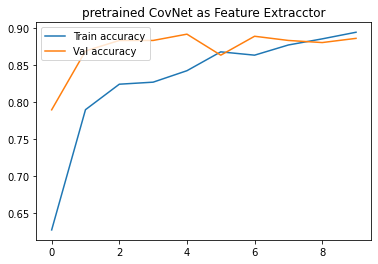

<Figure size 432x288 with 0 Axes>

In [ ]:
display_training_curves(history, "pretrained CovNet as Feature Extractor")